In [2]:
%matplotlib inline

In [3]:
import matplotlib.pyplot as plt

In [83]:
#!/bin/env python

import numpy as np
import cPickle as pickle
from os.path import join

from glob import glob

from scipy.integrate import quad
from scipy.interpolate import InterpolatedUnivariateSpline


def generate_inv_function(vals, x):
    norm = np.sum(vals)
    f_int = np.cumsum(vals)*1./norm
    assert(abs(f_int[-1]-1.)<1e-5)
    return InterpolatedUnivariateSpline(f_int, x, k=1)

def generate_inv_functions_from_2d_hist(data, x, y, z):
    
    data_1d_x_dict = dict()
    data_1d_y_dict = dict()
    
    xval = np.unique(data[x])
    yval = np.unique(data[y])
    xbins = len(xval)
    ybins = len(yval)
    pix_y = yval[1]-yval[0]
    pix_x = xval[1]-xval[0]
    pix_area = pix_x*pix_y

    # marginalize function over y
    data_2d = data[z].reshape(xbins, ybins)
    data_1d_x = data_2d.sum(axis=1)*pix_y
    
    data_1d_x_dict["inv_spline_0"] = generate_inv_function(data_1d_x, xval)
    data_1d_x_dict["spline_0"] = InterpolatedUnivariateSpline(xval, data_1d_x, k=1)
    data_1d_x_dict["raw_0"] = [xval, data_1d_x]
    
    
    for i in range(xbins):
        data_1d_y = data_2d[i]
        data_1d_y_dict["inv_spline_{}".format(i)] = generate_inv_function(data_1d_y, yval)
        data_1d_y_dict["spline_{}".format(i)] = InterpolatedUnivariateSpline(yval, data_1d_y, k=1)
        data_1d_y_dict["raw_{}".format(i)] = [yval, data_1d_y]
    return data_1d_x_dict, data_1d_y_dict

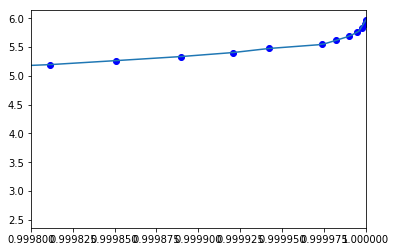

In [101]:
ant_path = "/home/lschumacher/antares/LL_ingredients/"
logE_range = [2.5, 6]
sindec_range = [-1., 0.8]
files = sorted(glob(join(ant_path, "*")))

for f in files:
    data = np.genfromtxt(f)
    identifier = f.split("/")[-1].split(".")[0]
    logE_sindec_pdf_dict = dict()
    s_mask = np.logical_and(data[:,0]>=sindec_range[0], data[:,0]<=sindec_range[1])
    e_mask = np.logical_and(data[:,1]>=logE_range[0], data[:,1]<=logE_range[1])
    mask = np.logical_and(s_mask, e_mask)
    logE_sindec_pdf_dict["sinDec"] = data[:,0][mask]
    logE_sindec_pdf_dict["logE"] = data[:,1][mask]
    logE_sindec_pdf_dict["value"] = data[:,2][mask]
    logE_sindec_pdf_dict["value"][logE_sindec_pdf_dict["value"]<=0] = min(logE_sindec_pdf_dict["value"][logE_sindec_pdf_dict["value"]>0])
    data_1d_x_dict, data_1d_y_dict = generate_inv_functions_from_2d_hist(logE_sindec_pdf_dict, "sinDec", "logE", "value")
    csum = np.cumsum(logE_sindec_pdf_dict["value"].reshape(xbins, ybins)[15])
    x = np.linspace(0.9998,1)
    plt.plot(csum/float(max(csum)), np.unique(logE_sindec_pdf_dict["logE"]), "bo")
    plt.plot(x, data_1d_y_dict["inv_spline_15"](x))
    plt.xlim(0.9998,1)
    #plt.semilogx()
    break

In [1]:
with open("/data/user/lschumacher/projects/stacking/antares/{}_1d_x.pkl".format(identifier), "wb") as f:
    pickle.dump(data_1d_x_dict, f)

with open("/data/user/lschumacher/projects/stacking/antares/{}_1d_y.pkl".format(identifier), "wb") as f:
    pickle.dump(data_1d_y_dict, f)

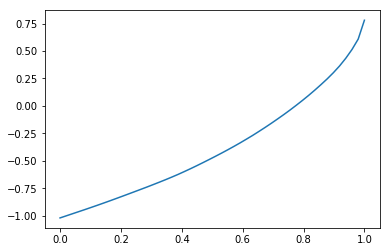

In [74]:
x = np.linspace(0,1)
plt.plot(x, data_1d_x_dict["spline_0"](x))

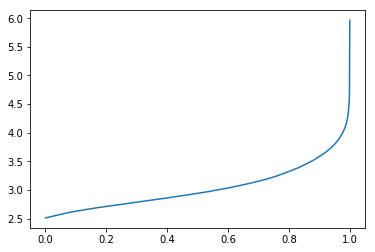

In [76]:
x = np.linspace(0,1, num=1000)
plt.plot(x, data_1d_y_dict["spline_0"](x))

In [45]:
with open("/data/user/lschumacher/projects/stacking/antares/{}_1d_x.pkl".format(identifier), "rb") as f:
    data_1d_x_dict = pickle.load(f)

with open("/data/user/lschumacher/projects/stacking/antares/{}_1d_y.pkl".format(identifier), "rb") as f:
    data_1d_y_dict = pickle.load(f)

<open file '/data/user/lschumacher/projects/stacking/antares/Bkg_PDF_1d_x.pkl', mode 'rb' at 0x7fdc55687c00>
